In [1]:
# Basics
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Models
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Misc
import sys
from IPython.display import clear_output

%run utils/utils_metrics.py

### 1. Load data

In [2]:
n_chunks = 1
chunks = [pkl.load(open('../data/bin_chunks/ttd_chunk_{0}.pkl'.format(i), 'rb')) for i in range(1, n_chunks + 1)]
dataset = pd.concat(chunks)
print("Data shape:", dataset.shape)
dataset.head()

Data shape: (48605, 10)


,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio
0,2016-02-16 19:56:06,2016-02-16 20:10:46,8.53,-73.995750,40.764488,-73.926292,40.867458,880,7.983998,1.068387
1,2016-02-11 10:23:41,2016-02-11 10:45:04,1.95,-73.994110,40.751068,-73.993401,40.736019,1283,1.039087,1.876648
2,2016-02-21 14:21:57,2016-02-21 14:30:07,0.50,-73.973160,40.752728,-73.982178,40.756962,490,0.556130,0.899070
3,2016-02-11 22:51:59,2016-02-11 22:57:41,1.30,-73.991280,40.744808,-73.985909,40.731178,342,0.981839,1.324045
4,2016-02-13 18:32:08,2016-02-13 18:43:51,1.50,-73.992897,40.741280,-73.975967,40.748734,703,1.026608,1.461123


### 2. Preprocessing

In [3]:
lat_data = np.array(pd.concat((dataset.pu_lat, dataset.do_lat))).reshape(-1,1)
lon_data = np.array(pd.concat((dataset.pu_lon, dataset.do_lon))).reshape(-1,1)
dur_data = np.array(dataset.duration.astype(float)).reshape(-1,1)
    
scaler_type = 'StandardScaler' # Other options: MinMaxScaler
lat_scaler = getattr(preprocessing, scaler_type)()
lon_scaler = getattr(preprocessing, scaler_type)()
out_scaler = getattr(preprocessing, scaler_type)()

lat_scaler.fit(lat_data);
lon_scaler.fit(lon_data);
out_scaler.fit(dur_data);

X = np.hstack((lat_scaler.transform(dataset[['pu_lat','do_lat',]]),
               lon_scaler.transform(dataset[['pu_lon','do_lon',]])))
y = out_scaler.transform(dur_data)

#### Quick look at inputs and output

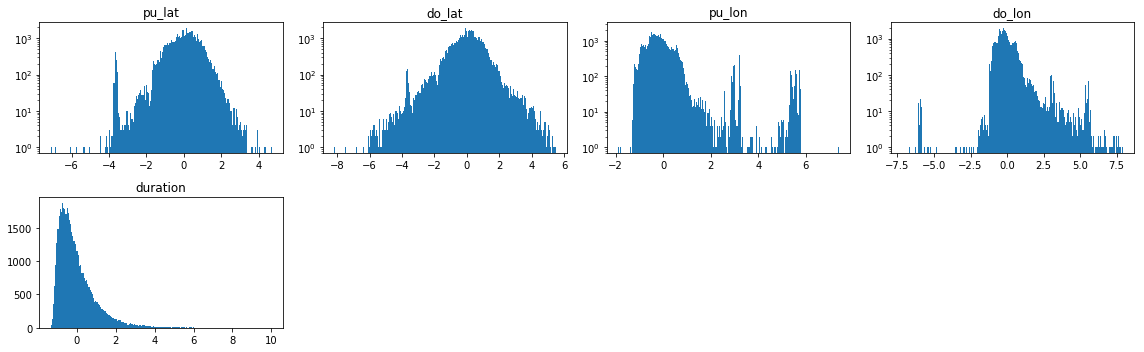

In [4]:
plt.figure(figsize=(16,5))
titles = ['pu_lat', 'do_lat', 'pu_lon', 'do_lon', 'duration']
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.hist(X[:,i], bins='auto', log=True)
    plt.title(titles[i])
plt.subplot(2,4,5)
plt.hist(y, bins='auto')
plt.title(titles[4])
plt.tight_layout()
plt.show()

### 3. Splitting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

test_size = len(y_test)
train_size = len(y_train)

y_test_denorm = out_scaler.inverse_transform(y_test)

In [ ]:
# # Store splitted data
pkl.dump(X_train, open('../splitted_data/fs0/x_train.dat', 'wb'))
pkl.dump(y_train, open('../splitted_data/fs0/y_train.dat', 'wb'))
pkl.dump(X_test, open('../splitted_data/fs0/x_test.dat', 'wb'))
pkl.dump(y_test, open('../splitted_data/fs0/y_test.dat', 'wb'))

In [5]:
# Read splitted data
X_train = pkl.load(open('../splitted_data/fs0/x_train.dat', 'rb'))
y_train = pkl.load(open('../splitted_data/fs0/y_train.dat', 'rb'))
X_test = pkl.load(open('../splitted_data/fs0/x_test.dat', 'rb'))
y_test = pkl.load(open('../splitted_data/fs0/y_test.dat', 'rb'))

test_size = len(y_test)
train_size = len(y_train)

y_test_denorm = out_scaler.inverse_transform(y_test)

### 4. SVM

In [6]:
kernels = ['linear', 'poly', 'rbf']
C_values = [0.1, 1, 10]

#### 4.1 Training

In [ ]:
for kern in kernels:
    for C in C_values:
        sys.stdout.write("\rTraining SVM with kernel {0} and C = {1}".format(kern,C))
        svm_reg = svm.SVR(kernel=kern, gamma='auto', C=C)
        svm_reg.fit(X_train, y_train.ravel())
        pkl.dump(svm_reg, open('../init_models/svms/fs0/svm_reg_{0}_{1}.mdl'.format(kern,C), 'wb'))
        sys.stdout.flush()
        clear_output()
sys.stdout.write("Done.")        

#### 4.2 Testing

In [10]:
y_pred_svm = []
for kern in kernels:
    for C in C_values:
        print("Running tests on SVM with kernel {0} and C = {1}".format(kern,C))
        svm_reg = pkl.load(open('../init_models/svms/fs0/svm_reg_{0}_{1}.mdl'.format(kern,C), 'rb'))
        y_pred_svm.append(svm_reg.predict(X_test))
        sys.stdout.flush()
        clear_output()
sys.stdout.write("Done.")        

Done.

#### Denormalize predicited data

In [11]:
y_pred_svm_denorm = out_scaler.inverse_transform(y_pred_svm)

# Set all negative outputs to zero (we're predicting time)
y_pred_svm_denorm[y_pred_svm_denorm < 0] = 0

# Transform back again
y_pred_svm = out_scaler.transform(y_pred_svm_denorm)

#### 4.3 Metrics

In [25]:
idx = pd.MultiIndex.from_tuples([(k,C) for k in ['linear','poly','rbf'] for C in [0.1, 1, 10]], names=['Kernel','C'])

metrics_svm = compute_metrics(y_true = y_test, y_pred = y_pred_svm, 
                              y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_svm_denorm, 
                              indices = idx)  
metrics_svm

Exp. Var.        R2            MSE        RMSE      nMSE  \
Kernel C                                                                
linear 0.1    0.196927  0.171032  279541.417587  528.716765  0.811739   
       1.0    0.196874  0.171053  279534.302127  528.710036  0.811719   
       10.0   0.196932  0.171063  279531.057536  528.706968  0.811709   
poly   0.1    0.295725  0.263299  248427.446267  498.424966  0.721390   
       1.0    0.295649  0.263252  248443.169233  498.440738  0.721436   
       10.0   0.295680  0.263246  248445.468417  498.443044  0.721442   
rbf    0.1    0.678967  0.670438  111133.534751  333.366967  0.322712   
       1.0    0.693246  0.686591  105686.453951  325.094531  0.306895   
       10.0   0.695185  0.689553  104687.838989  323.555001  0.303995   

                nRMSE      MSLE     RMSLE  
Kernel C                                   
linear 0.1   0.900966  0.546432  0.739210  
       1.0   0.900954  0.546551  0.739291  
       10.0  0.900949  0.546441  0.739217  
poly   0.1   0.849347  0.612487  0.782616  
       1.0   0.849374  0.612975  0.782927  
       10.0  0.849378  0.612947  0.782909  
rbf    0.1   0.568078  0.179846  0.424083  
       1.0   0.553981  0.164408  0.405473  
       10.0  0.551358  0.164839  0.406004

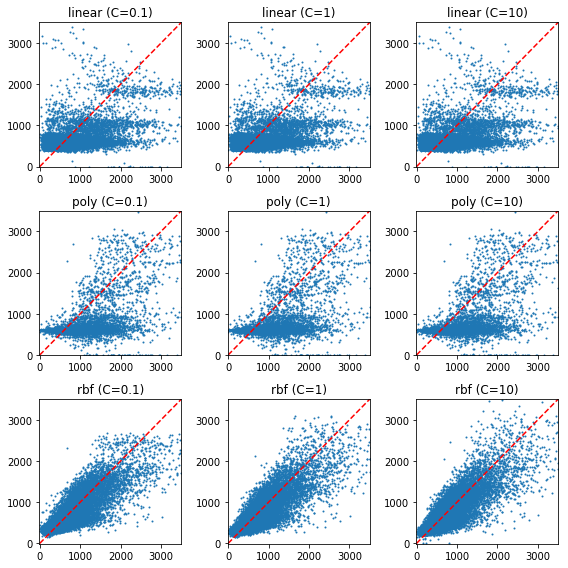

In [43]:
fig = plt.figure(figsize=(8,8))
for i,kern in enumerate(kernels):
    for j,C in enumerate(C_values):
        plt.subplot(3, 3, j + 3*i + 1)
        plt.scatter(y_test_denorm, y_pred_svm_denorm[j + 3*i], s = 1)
        plt.plot((-1,3500),(-1,3500), '--', c='r')
        plt.title('{0} (C={1})'.format(kern,C))
        plt.xlim((-10,3500))
        plt.ylim((-10,3500))
plt.tight_layout()
plt.show()

#### 4.4 Evaluate accuracy agains range of tolerance for best SVM

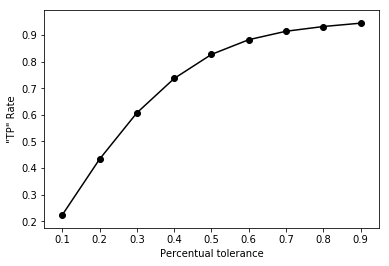

In [49]:
y_pred_svm_best = y_pred_svm_denorm[8].reshape(-1,1)

tolerance = np.arange(0.1,1,0.1)
acc = [np.sum(np.isclose(y_pred_svm_best, y_test_denorm, rtol=tol))/test_size for tol in tolerance]

plt.plot(tolerance, acc, c='k')
plt.scatter(tolerance, acc, c='k')
plt.ylabel('"TP" Rate')
plt.xlabel('Percentual tolerance')
plt.show()

### 5. Random Forests

In [48]:
forest_size = [50,100,150,200,250, 300]
max_feats   = [2,3,4]

#### 5.1 Training

In [ ]:
for n_trees in forest_size:
    for max_feat in max_feats:
        sys.stdout.write("\rTraining forest with {0} trees using maximum of {1} features".format(n_trees, max_feat))
        rf_reg = RandomForestRegressor(n_estimators=n_trees, max_features=max_feat, n_jobs=2)
        rf_reg.fit(X_train, y_train.ravel())
        pkl.dump(rf_reg, open('../init_models/fs0/random_forests/rf_reg_{0}_{1}.mdl'.format(n_trees,max_feat), 'wb'))
        sys.stdout.flush()
clear_output()
sys.stdout.write("Done.")        

#### 5.2 Testing

In [51]:
y_pred_rf = []
for n_trees in forest_size:
    for max_feat in max_feats:
        sys.stdout.write("\rTesting forest with {0} trees using maximum of {1} features".format(n_trees, max_feat))
        rf_reg = pkl.load(open('../init_models/fs0/random_forests/rf_reg_{0}_{1}.mdl'.format(n_trees,max_feat), 'rb'))
        y_pred_rf.append(rf_reg.predict(X_test));
        sys.stdout.flush()
clear_output()
sys.stdout.write("Done.")        

Done.

#### Denormalize predicited data

In [75]:
y_pred_rf_denorm = out_scaler.inverse_transform(y_pred_rf)

# Set all negative outputs to zero (we're predicting time)
y_pred_rf_denorm[y_pred_rf_denorm < 0] = 0

# Transform back again
y_pred_rf = out_scaler.transform(y_pred_rf_denorm)

#### 4.3 Metrics

In [78]:
idx = pd.MultiIndex.from_tuples([(f,m) for f in forest_size for m in max_feats], names=['#Tress','MaxFeat'])

metrics_svm = compute_metrics(y_true = y_test, y_pred = y_pred_rf, 
                              y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_rf_denorm, 
                              indices = idx)  
metrics_svm

Exp. Var.        R2            MSE        RMSE      nMSE  \
#Tress MaxFeat                                                             
50     2         0.694839  0.694687  102956.340628  320.868105  0.298967   
       3         0.690971  0.690730  104290.950328  322.941094  0.302843   
       4         0.684011  0.683804  106626.245396  326.536744  0.309624   
100    2         0.698139  0.698026  101830.526200  319.108957  0.295698   
       3         0.696103  0.695904  102546.206694  320.228366  0.297776   
       4         0.687535  0.687319  105441.158868  324.717044  0.306183   
150    2         0.699542  0.699428  101357.880317  318.367524  0.294326   
       3         0.696279  0.696094  102482.106406  320.128266  0.297590   
       4         0.687783  0.687584  105351.732463  324.579316  0.305923   
200    2         0.701697  0.701579  100632.392338  317.226090  0.292219   
       3         0.696486  0.696309  102409.355816  320.014618  0.297379   
       4         0.690195  0.689978  104544.267229  323.333059  0.303578   
250    2         0.701520  0.701397  100693.605559  317.322558  0.292397   
       3         0.698089  0.697925  101864.692669  319.162486  0.295797   
       4         0.689732  0.689532  104694.795212  323.565751  0.304015   
300    2         0.701110  0.700991  100830.588747  317.538326  0.292794   
       3         0.696779  0.696582  102317.333306  319.870807  0.297112   
       4         0.689731  0.689529  104695.688793  323.567132  0.304018   

                   nRMSE      MSLE     RMSLE  
#Tress MaxFeat                                
50     2        0.546779  0.162316  0.402885  
       3        0.550311  0.162998  0.403730  
       4        0.556439  0.165172  0.406414  
100    2        0.543781  0.160908  0.401133  
       3        0.545689  0.161394  0.401738  
       4        0.553338  0.163803  0.404726  
150    2        0.542518  0.161211  0.401511  
       3        0.545518  0.160340  0.400425  
       4        0.553103  0.162869  0.403570  
200    2        0.540573  0.160028  0.400035  
       3        0.545325  0.160071  0.400089  
       4        0.550979  0.161984  0.402472  
250    2        0.540737  0.160079  0.400098  
       3        0.543872  0.159574  0.399467  
       4        0.551376  0.162251  0.402804  
300    2        0.541105  0.160145  0.400181  
       3        0.545080  0.160061  0.400076  
       4        0.551378  0.162259  0.402814

### 6. XGBoost

In [6]:
xgb_reg = xgb.XGBRegressor(n_estimators=300, max_depth=10)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [7]:
y_pred_xgb = xgb_reg.predict(X_test).reshape(1,-1)

In [8]:
y_pred_xgb_denorm = out_scaler.inverse_transform(y_pred_xgb)

# Set all negative outputs to zero (we're predicting time)
y_pred_xgb_denorm[y_pred_xgb_denorm < 0] = 0

# Transform back again
y_pred_xgb = out_scaler.transform(y_pred_xgb_denorm)

In [9]:
compute_metrics(y_true = y_test, y_pred = y_pred_xgb,
                y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_xgb_denorm,
                indices=[0])

,Exp. Var.,R2,MSE,RMSE,nMSE,nRMSE,MSLE,RMSLE
0,0.678408,0.678313,108477.938111,329.359891,0.315001,0.561249,0.168962,0.41105


### 7. Neural Network

In [10]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(100,4))

In [11]:
mlp_reg.fit(X_train, y_train.ravel())

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [12]:
y_pred_mlp = mlp_reg.predict(X_test).reshape(1,-1)

In [13]:
y_pred_mlp_denorm = out_scaler.inverse_transform(y_pred_mlp)

# Set all negative outputs to zero (we're predicting time)
y_pred_mlp_denorm[y_pred_mlp_denorm < 0] = 0

# Transform back again
y_pred_mlp = out_scaler.transform(y_pred_mlp_denorm)

In [14]:
compute_metrics(y_true = y_test, y_pred = y_pred_mlp,
                y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_mlp_denorm,
                indices=[0])

,Exp. Var.,R2,MSE,RMSE,nMSE,nRMSE,MSLE,RMSLE
0,0.708305,0.708265,98377.921594,313.652549,0.285672,0.534483,0.15276,0.390845


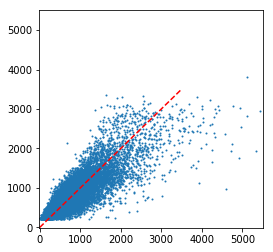

In [15]:
fig = plt.figure(figsize=(4,4))
plt.scatter(y_test_denorm, y_pred_mlp_denorm, s = 1)
plt.plot((-1,3500),(-1,3500), '--', c='r')
plt.xlim((-10,5500))
plt.ylim((-10,5500))
plt.show()